In [1]:
import pandas as pd
import numpy as np
import re
import requests
from numpy import std
from google.cloud import bigquery
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from collections import Counter, defaultdict

import ortools
import ortools.graph.pywrapgraph
from k_means_constrained import KMeansConstrained


import os
from collections import defaultdict

from joblib import dump, load

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from seaborn import heatmap
import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime
import itertools
import hdbscan

pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
bqclient = bigquery.Client()
query_string = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_kpi_20230412` as skpi
    WHERE skpi.sales_country = "germany" AND NOT skpi.shop_state = "TERMINATED" AND skpi.months_with_conrad >= 6
"""
seller_base_df =  bqclient.query(query_string).result().to_dataframe()


seller_base_df.shape

(730, 82)

In [3]:
seller_df = seller_base_df.copy()

In [4]:
seller_base_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,months_with_conrad,is_fds,is_net_seller,tax_identification_number,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,corporate_name,company_type
0,2379,Epotronic GmbH,SUSPENDED,germany,germany,False,2019-10-28,42,False,False,DE313525966,2020-10-08,2020-10-08,NaT,<NA>,<NA>,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,3,20,41,234,None,other
1,2526,Moog,SUSPENDED,germany,germany,False,2020-02-17,38,False,False,DE145165479,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,None,other
2,2708,K11_Ersatzteilshop,OPEN,germany,germany,False,2020-10-19,30,False,False,DE140206628,2021-02-25,2021-03-15,2021-04-15,<NA>,31,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,3,0,0,0,0,K11 Ersatzteilshop GmbH,GmbH
3,2851,ConnectedView,OPEN,germany,germany,False,2021-01-27,27,False,False,DE334333193,2021-07-20,2021-10-19,NaT,<NA>,<NA>,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,ConnectedView GmbH,GmbH
4,2982,GS-System GmbH,OPEN,germany,germany,False,2021-06-07,22,False,False,DE267781585,2021-07-05,2021-07-07,2022-08-19,<NA>,408,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72,0,1,1,8,0,0,0,0,GS-System GmbH,GmbH


In [5]:
second_dataset = seller_base_df.columns

In [6]:
first_dataset = ['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'is_fds', 'date_contract_end',
       'is_net_seller', 'tax_identification_number', 'corporate_name',
       'current_stage', 'seller_ranking', 'aggregator', 'article_potential',
       'article_go_live', 'gmv_potential_first_year', 'date_start_of_sales_fc',
       'is_lighthouse_partner', 'account_manager', 'business_developer',
       'technical_onboarding_manager', 'is_active_oci_seller',
       'is_gmv_relevant_for_current_year', 'date_contact', 'date_interest',
       'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active',
       'date_parking', 'date_lost', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'purchased_offers_mp_6m',
       'purchased_offers_oci_1m', 'purchased_offers_oci_3m',
       'purchased_offers_oci_6m', 'purchased_products_mp_1m',
       'purchased_products_mp_3m', 'purchased_products_mp_6m',
       'purchased_products_oci_1m', 'purchased_products_oci_3m',
       'purchased_products_oci_6m', 'customers_mp_1m', 'customers_mp_3m',
       'customers_mp_6m', 'customers_oci_1m', 'customers_oci_3m',
       'customers_oci_6m', 'orders_mp_1m', 'orders_mp_3m', 'orders_mp_6m',
       'orders_oci_1m', 'orders_oci_3m', 'orders_oci_6m',
       'ordered_units_mp_1m', 'ordered_units_mp_3m', 'ordered_units_mp_6m',
       'ordered_units_oci_1m', 'ordered_units_oci_3m', 'ordered_units_oci_6m',
       'sales_mp_1m', 'sales_mp_3m', 'sales_mp_6m', 'sales_oci_1m',
       'sales_oci_3m', 'sales_oci_6m', 'commission_mp_1m', 'commission_mp_3m',
       'commission_mp_6m', 'pdpv_mp_active_1m', 'pdpv_mp_active_3m',
       'pdpv_mp_active_6m', 'pdpv_mp_inactive_1m', 'pdpv_mp_inactive_3m',
       'pdpv_mp_inactive_6m']

In [7]:
list(set(second_dataset) - set(first_dataset))

['company_type',
 'purchased_offers_mp_12m',
 'customers_mp_12m',
 'customers_oci_12m',
 'orders_mp_12m',
 'sales_oci_12m',
 'sales_mp_12m',
 'purchased_products_mp_12m',
 'ordered_units_oci_12m',
 'purchased_products_oci_12m',
 'purchased_offers_oci_12m',
 'ordered_units_mp_12m',
 'pdpv_mp_inactive_12m',
 'orders_oci_12m',
 'commission_mp_12m',
 'pdpv_mp_active_12m',
 'months_with_conrad']

In [8]:
list(set(first_dataset) - set(second_dataset))

['date_lost',
 'date_pool',
 'date_won_active',
 'is_lighthouse_partner',
 'date_parking',
 'article_potential',
 'date_won_kyc',
 'aggregator',
 'date_onboarding',
 'date_interest',
 'date_contract_end',
 'technical_onboarding_manager',
 'is_gmv_relevant_for_current_year',
 'date_start_of_sales_fc',
 'seller_ranking',
 'current_stage',
 'date_contact',
 'business_developer',
 'article_go_live',
 'is_active_oci_seller',
 'gmv_potential_first_year',
 'account_manager']

In [9]:
seller_df = seller_base_df.copy()
seller_base_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,months_with_conrad,is_fds,is_net_seller,tax_identification_number,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,corporate_name,company_type
0,2379,Epotronic GmbH,SUSPENDED,germany,germany,False,2019-10-28,42,False,False,DE313525966,2020-10-08,2020-10-08,NaT,<NA>,<NA>,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,3,20,41,234,None,other
1,2526,Moog,SUSPENDED,germany,germany,False,2020-02-17,38,False,False,DE145165479,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,None,other
2,2708,K11_Ersatzteilshop,OPEN,germany,germany,False,2020-10-19,30,False,False,DE140206628,2021-02-25,2021-03-15,2021-04-15,<NA>,31,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,3,0,0,0,0,K11 Ersatzteilshop GmbH,GmbH
3,2851,ConnectedView,OPEN,germany,germany,False,2021-01-27,27,False,False,DE334333193,2021-07-20,2021-10-19,NaT,<NA>,<NA>,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,ConnectedView GmbH,GmbH
4,2982,GS-System GmbH,OPEN,germany,germany,False,2021-06-07,22,False,False,DE267781585,2021-07-05,2021-07-07,2022-08-19,<NA>,408,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72,0,1,1,8,0,0,0,0,GS-System GmbH,GmbH


In [10]:
seller_base_df.dtypes

shop_id                         Int64  
shop_name                       object 
shop_state                      object 
sales_country                   object 
origin_country                  object 
is_crossborder                  boolean
date_created                    dbdate 
months_with_conrad              Int64  
is_fds                          boolean
is_net_seller                   boolean
tax_identification_number       object 
date_first_open                 dbdate 
date_first_article_active       dbdate 
date_first_order                dbdate 
days_in_technical_onboarding    Int64  
days_to_first_sale              Int64  
offers_active_mp                Int64  
offers_inactive_mp              Int64  
offers_active_oci               Int64  
offers_inactive_oci             Int64  
purchased_offers_mp_1m          Int64  
purchased_offers_mp_3m          Int64  
purchased_offers_mp_6m          Int64  
purchased_offers_mp_12m         Int64  
purchased_offers_oci_1m         Int64  


In [11]:
seller_base_df.shape

(730, 82)

In [12]:
659 + 71

730

In [13]:
seller_base_df[['is_crossborder', 'is_fds', 'is_net_seller']].head()

,is_crossborder,is_fds,is_net_seller
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


In [14]:
seller_base_df.is_net_seller.value_counts()

False    730
Name: is_net_seller, dtype: Int64

In [15]:
drop_cols = ['shop_id', 'shop_name', 'sales_country',  'origin_country', 'is_crossborder', 
             'is_net_seller', 'tax_identification_number', 'corporate_name', 'is_crossborder', 'is_net_seller']
boolean_cols = ['is_fds']


In [16]:
seller_base_df.drop(columns=drop_cols, axis=1, inplace=True)


In [17]:
seller_base_df['shop_state'].unique()

array(['SUSPENDED', 'OPEN', 'CLOSE'], dtype=object)

In [18]:
seller_base_df = pd.concat([seller_base_df, pd.get_dummies(seller_base_df["shop_state"],prefix="shop_state_cat")], axis=1)
seller_base_df.drop(columns=["shop_state"], axis=1, inplace=True)

seller_base_df.head()

,date_created,months_with_conrad,is_fds,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED
0,2019-10-28,42,False,2020-10-08,2020-10-08,NaT,<NA>,<NA>,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,3,20,41,234,other,0,0,1
1,2020-02-17,38,False,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,other,0,0,1
2,2020-10-19,30,False,2021-02-25,2021-03-15,2021-04-15,<NA>,31,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,3,0,0,0,0,GmbH,0,1,0
3,2021-01-27,27,False,2021-07-20,2021-10-19,NaT,<NA>,<NA>,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,GmbH,0,1,0
4,2021-06-07,22,False,2021-07-05,2021-07-07,2022-08-19,<NA>,408,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72,0,1,1,8,0,0,0,0,GmbH,0,1,0


In [19]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]


In [20]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []
  
    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins

In [21]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)

In [22]:
boolean_dict = {True: 1, False:0, "Other":99, "<NA>":99, "NA":99, "nan": 99, "NaN": 99, None: 99}
def convert_boolean_cols(df , col, boolean_dict):
    df[col].fillna("Other", inplace=True)
    df[col] = df[col].map(boolean_dict)
    return df

# days_in_technical_onboarding

<AxesSubplot:>

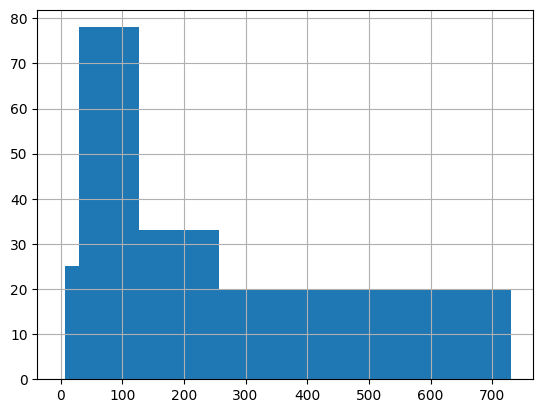

In [23]:
days_in_technical_onboarding_bins = [-1, seller_base_df.days_in_technical_onboarding.min(), 30, seller_base_df.days_in_technical_onboarding.mean(), seller_base_df.days_in_technical_onboarding.mean() + std(seller_base_df.days_in_technical_onboarding), seller_base_df.days_in_technical_onboarding.max() +1 ]
seller_base_df.days_in_technical_onboarding.hist(bins=days_in_technical_onboarding_bins)

In [24]:
seller_base_df.days_in_technical_onboarding.value_counts(bins=days_in_technical_onboarding_bins)

(30.0, 127.571]       78
(127.571, 257.322]    33
(8.0, 30.0]           23
(257.322, 730.0]      20
(-1.001, 8.0]         2 
Name: days_in_technical_onboarding, dtype: int64

In [25]:
seller_base_df['days_in_technical_onboarding'] = pd.cut(seller_base_df.days_in_technical_onboarding, days_in_technical_onboarding_bins).cat.codes
seller_base_df['days_in_technical_onboarding'].value_counts()

-1    574
 2    78 
 3    33 
 1    23 
 4    20 
 0    2  
Name: days_in_technical_onboarding, dtype: int64

# days_to_first_sale

In [26]:
seller_base_df.days_to_first_sale.min(), seller_base_df.days_to_first_sale.mean(), seller_base_df.days_to_first_sale.max(), std(seller_base_df.days_to_first_sale)


(-559, 1.7454175152749491, 959, 141.6266511072266)

<AxesSubplot:>

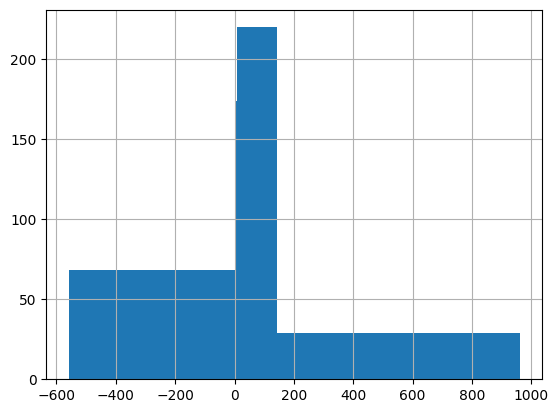

In [27]:
days_to_first_sale_bins = [seller_base_df.days_to_first_sale.min(), 0, 7,seller_base_df.days_to_first_sale.mean() + std(seller_base_df.days_to_first_sale), seller_base_df.days_to_first_sale.max() +1 ]
seller_base_df.days_to_first_sale.hist(bins=days_to_first_sale_bins)

In [28]:
seller_base_df.days_to_first_sale.value_counts(bins=days_to_first_sale_bins)

(7.0, 143.372]      206
(0.0, 7.0]          150
(-559.001, 0.0]     106
(143.372, 960.0]    29 
Name: days_to_first_sale, dtype: int64

In [29]:
seller_base_df['days_to_first_sale'] = pd.cut(seller_base_df.days_to_first_sale, days_to_first_sale_bins).cat.codes
seller_base_df['days_to_first_sale'].value_counts()

-1    240
 2    206
 1    150
 0    105
 3    29 
Name: days_to_first_sale, dtype: int64

# Offer Columns

In [30]:
seller_base_df.offers_active_mp.min(), seller_base_df.offers_active_mp.mean(), seller_base_df.offers_active_mp.max(), std(seller_base_df.offers_active_mp)


(0, 10658.239726027397, 479757, 45896.54714190798)

In [31]:
seller_base_df.offers_inactive_mp.min(), seller_base_df.offers_inactive_mp.mean(), seller_base_df.offers_inactive_mp.max(), std(seller_base_df.offers_inactive_mp)


(0, 5249.986301369863, 918752, 40995.52511222669)

In [32]:
seller_base_df.offers_active_oci.min(), seller_base_df.offers_active_oci.mean(), seller_base_df.offers_active_oci.max(), std(seller_base_df.offers_active_oci)


(0, 5411.627397260274, 440794, 39885.761507095405)

In [33]:
seller_base_df.offers_inactive_oci.min(), seller_base_df.offers_inactive_oci.mean(), seller_base_df.offers_inactive_oci.max(), std(seller_base_df.offers_inactive_oci)


(0, 1707.9136986301369, 554764, 22470.51330374204)

offers_active_mp
offers_inactive_mp
offers_active_oci
offers_inactive_oci


,date_created,months_with_conrad,is_fds,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED
0,2019-10-28,42,False,2020-10-08,2020-10-08,NaT,-1,-1,-1,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,3,20,41,234,other,0,0,1
1,2020-02-17,38,False,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,other,0,0,1
2,2020-10-19,30,False,2021-02-25,2021-03-15,2021-04-15,-1,2,1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,3,0,0,0,0,GmbH,0,1,0
3,2021-01-27,27,False,2021-07-20,2021-10-19,NaT,-1,-1,-1,0,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,GmbH,0,1,0
4,2021-06-07,22,False,2021-07-05,2021-07-07,2022-08-19,-1,3,1,-1,-1,-1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72,0,1,1,8,0,0,0,0,GmbH,0,1,0


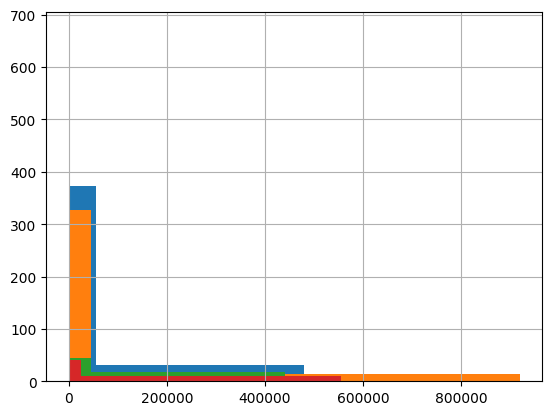

In [34]:
offer_cols = ['offers_active_mp', 'offers_inactive_mp', 'offers_active_oci', 'offers_inactive_oci']
for col in offer_cols:
    print(col)
    offer_bins = [seller_base_df[col].min(),1, 10, seller_base_df[col].mean() + std(seller_base_df[col]), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [35]:
seller_base_df.columns

Index(['date_created', 'months_with_conrad', 'is_fds', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'purchased_offers_mp_6m',
       'purchased_offers_mp_12m', 'purchased_offers_oci_1m',
       'purchased_offers_oci_3m', 'purchased_offers_oci_6m',
       'purchased_offers_oci_12m', 'purchased_products_mp_1m',
       'purchased_products_mp_3m', 'purchased_products_mp_6m',
       'purchased_products_mp_12m', 'purchased_products_oci_1m',
       'purchased_products_oci_3m', 'purchased_products_oci_6m',
       'purchased_products_oci_12m', 'customers_mp_1m', 'customers_mp_3m',
       'customers_mp_6m', 'customers_mp_12m', 'customers_oci_1m',
       'customers_oci_3m', 'customers_oci_6m', 'customers_oci_12m',
       'orders_mp_1m', 'orders_mp_3m'

In [36]:
periodic_cols = ['purchased_offers_mp_1m', 'purchased_offers_mp_3m' , 'purchased_offers_mp_6m', 'purchased_offers_mp_12m',
                 'purchased_offers_oci_1m', 'purchased_offers_oci_3m' , 'purchased_offers_oci_6m', 'purchased_offers_oci_12m',
                 'purchased_products_mp_1m', 'purchased_products_mp_3m' , 'purchased_products_mp_6m', 'purchased_products_mp_12m',
                 'purchased_products_oci_1m', 'purchased_products_oci_3m' , 'purchased_products_oci_6m', 'purchased_products_oci_12m',
                 'customers_mp_1m', 'customers_mp_3m' , 'customers_mp_6m', 'customers_mp_12m',
                 'customers_oci_1m', 'customers_oci_3m' , 'customers_oci_6m', 'customers_oci_12m',
                 'orders_mp_1m', 'orders_mp_3m' , 'orders_mp_6m', 'orders_mp_12m',
                 'orders_oci_1m', 'orders_oci_3m' , 'orders_oci_6m', 'orders_oci_12m',
                 'ordered_units_mp_1m', 'ordered_units_mp_3m' , 'ordered_units_mp_6m', 'ordered_units_mp_12m',
                 'ordered_units_oci_1m', 'ordered_units_oci_3m' , 'ordered_units_oci_6m', 'ordered_units_oci_12m',
                 'sales_mp_1m', 'sales_mp_3m' , 'sales_mp_6m', 'sales_mp_12m',
                 'sales_oci_1m', 'sales_oci_3m' , 'sales_oci_6m', 'sales_oci_12m',
                 'commission_mp_1m', 'commission_mp_3m' , 'commission_mp_6m', 'commission_mp_12m',
                 'pdpv_mp_active_1m', 'pdpv_mp_active_3m' , 'pdpv_mp_active_6m', 'pdpv_mp_active_12m',
                 'pdpv_mp_inactive_1m', 'pdpv_mp_inactive_3m' , 'pdpv_mp_inactive_6m', 'pdpv_mp_inactive_12m']


purchased_offers_mp_1m
purchased_offers_mp_3m
purchased_offers_mp_6m
purchased_offers_mp_12m
purchased_offers_oci_1m
purchased_offers_oci_3m
purchased_offers_oci_6m
purchased_offers_oci_12m
purchased_products_mp_1m
purchased_products_mp_3m
purchased_products_mp_6m
purchased_products_mp_12m
purchased_products_oci_1m
purchased_products_oci_3m
purchased_products_oci_6m
purchased_products_oci_12m
customers_mp_1m
customers_mp_3m
customers_mp_6m
customers_mp_12m
customers_oci_1m
customers_oci_3m
customers_oci_6m
customers_oci_12m
orders_mp_1m
orders_mp_3m
orders_mp_6m
orders_mp_12m
orders_oci_1m
orders_oci_3m
orders_oci_6m
orders_oci_12m
ordered_units_mp_1m
ordered_units_mp_3m
ordered_units_mp_6m
ordered_units_mp_12m
ordered_units_oci_1m
ordered_units_oci_3m
ordered_units_oci_6m
ordered_units_oci_12m
sales_mp_1m
sales_mp_3m
sales_mp_6m
sales_mp_12m
sales_oci_1m
sales_oci_3m
sales_oci_6m
sales_oci_12m
commission_mp_1m
commission_mp_3m
commission_mp_6m
commission_mp_12m
pdpv_mp_active_1m
pdpv_

,date_created,months_with_conrad,is_fds,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED
0,2019-10-28,42,False,2020-10-08,2020-10-08,NaT,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,other,0,0,1
1,2020-02-17,38,False,NaT,NaT,NaT,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,other,0,0,1
2,2020-10-19,30,False,2021-02-25,2021-03-15,2021-04-15,-1,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,GmbH,0,1,0
3,2021-01-27,27,False,2021-07-20,2021-10-19,NaT,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,GmbH,0,1,0
4,2021-06-07,22,False,2021-07-05,2021-07-07,2022-08-19,-1,3,1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,0,0,1,-1,-1,-1,-1,GmbH,0,1,0


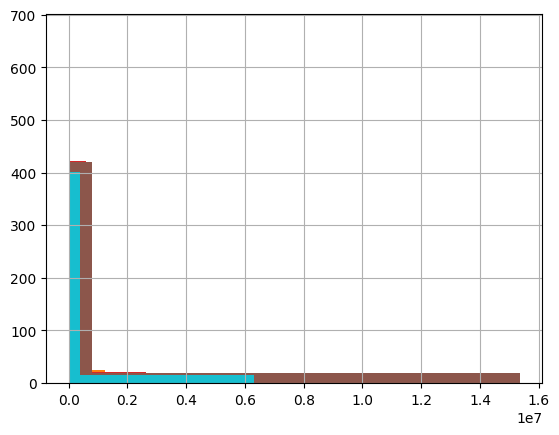

In [37]:
%%time
for col in periodic_cols:
    print(col)
    offer_bins = [seller_base_df[col].min(),1, seller_base_df[col].mean() + std(seller_base_df[col]), seller_base_df[col].max() +1 ]
    seller_base_df[col].hist(bins=offer_bins)
    seller_base_df[col] = pd.cut(seller_base_df[col], offer_bins).cat.codes
seller_base_df.head()

In [38]:
for col in boolean_cols:
    print(col)
    print(seller_base_df[col].value_counts())
    seller_base_df[col] = False


is_fds
False    659
True     71 
Name: is_fds, dtype: Int64


In [39]:
for col in boolean_cols:
    seller_base_df[col].fillna("Other", inplace=True)
    seller_base_df[col] = seller_base_df[col].map(boolean_dict)
    seller_base_df[col].value_counts()

In [40]:
seller_base_df['is_fds'].value_counts()

0    730
Name: is_fds, dtype: int64

In [41]:
date_cols2 = ['date_created', 'date_contract_end', 'date_start_of_sales_fc', 'date_contact', 'date_interest', 
             'date_pool', 'date_onboarding', 'date_won_kyc', 'date_won_active', 'date_parking', 
             'date_lost', 'date_first_open', 'date_first_article_active', 'date_first_order']
date_cols = ['date_created', 'date_first_open',
             'date_first_article_active', 'date_first_order']
len(date_cols)

4

In [42]:
for col in date_cols:
    print(col)
    #print(seller_base_df[col].min(), ' - ', seller_base_df[col].max())
    seller_base_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_base_df[col] = pd.to_datetime(seller_base_df[col])

date_created
date_first_open
date_first_article_active
date_first_order


In [43]:
seller_base_df["date_created_day"] = seller_base_df['date_created'].map(lambda x: x.day)
seller_base_df["date_created_month"] = seller_base_df['date_created'].map(lambda x: x.month)
seller_base_df["date_created_year"] = seller_base_df['date_created'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_created"], axis=1, inplace=True)
##############
seller_base_df["date_first_open_day"] = seller_base_df['date_first_open'].map(lambda x: x.day)
seller_base_df["date_first_open_month"] = seller_base_df['date_first_open'].map(lambda x: x.month)
seller_base_df["date_first_open_year"] = seller_base_df['date_first_open'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_open"], axis=1, inplace=True)
##############
seller_base_df["date_first_article_active_day"] = seller_base_df['date_first_article_active'].map(lambda x: x.day)
seller_base_df["date_first_article_active_month"] = seller_base_df['date_first_article_active'].map(lambda x: x.month)
seller_base_df["date_first_article_active_year"] = seller_base_df['date_first_article_active'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_article_active"], axis=1, inplace=True)
##############
seller_base_df["date_first_order_day"] = seller_base_df['date_first_order'].map(lambda x: x.day)
seller_base_df["date_first_order_month"] = seller_base_df['date_first_order'].map(lambda x: x.month)
seller_base_df["date_first_order_year"] = seller_base_df['date_first_order'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_order"], axis=1, inplace=True)

# company_type

In [44]:
seller_base_df['company_type'].unique()

array(['other', 'GmbH', 'Co. KG', 'AG'], dtype=object)

In [45]:
company_type_dictionary = dict(zip(seller_base_df['company_type'].unique() , np.arange(1, len(seller_base_df['company_type'].unique()) + 1, 1).tolist()))
seller_base_df['company_type'] = seller_base_df['company_type'].map(company_type_dictionary)
seller_base_df['company_type'].nunique()

4

# HDBSCAN

In [46]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, leaf_size=10)
clusterer

CPU times: user 42 µs, sys: 9 µs, total: 51 µs
Wall time: 55.3 µs


HDBSCAN(leaf_size=10, min_samples=5)

In [47]:
%%time
clusterer.fit(seller_base_df)
clusterer

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 98 ms


HDBSCAN(leaf_size=10, min_samples=5)

In [48]:
clusterer.labels_.max(), clusterer.labels_.min()


(3, -1)

In [49]:
print(Counter(clusterer.labels_))


Counter({3: 492, 1: 150, 0: 48, 2: 26, -1: 14})


In [50]:
%%time
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg_hdbscan = silhouette_score(seller_base_df, clusterer.labels_)
print("For n_clusters =", clusterer.labels_.max(), "The average silhouette_score is :", silhouette_avg_hdbscan)

For n_clusters = 3 The average silhouette_score is : 0.2421528164746252
CPU times: user 36.5 ms, sys: 27.6 ms, total: 64.1 ms
Wall time: 24.3 ms


# KMeans Clustering

In [51]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 

In [52]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [53]:
seller_base_df = reduce_mem_usage(seller_base_df)


Mem. usage decreased to  0.07 Mb (49.4% reduction)


In [54]:
K = range(8,20)

In [55]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [56]:
clf = KMeansConstrained(
             n_clusters=9,
             size_min=10,
             size_max=170,
             random_state=20
)
clf.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf.labels_)
print(color.BOLD + "For n_clusters =", str(clf.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({1: 108, 2: 105, 3: 103, 4: 101, 8: 100, 5: 84, 7: 49, 6: 49, 0: 31})
For n_clusters = 9 The average silhouette_score is : 0.23338924952456278


In [57]:
seller_base_df['seller_segments'] = clf.labels_
seller_df['seller_segments'] = clf.labels_



In [58]:
seller_df.head()

,shop_id,shop_name,shop_state,sales_country,origin_country,is_crossborder,date_created,months_with_conrad,is_fds,is_net_seller,tax_identification_number,date_first_open,date_first_article_active,date_first_order,days_in_technical_onboarding,days_to_first_sale,offers_active_mp,offers_inactive_mp,offers_active_oci,offers_inactive_oci,purchased_offers_mp_1m,purchased_offers_mp_3m,purchased_offers_mp_6m,purchased_offers_mp_12m,purchased_offers_oci_1m,purchased_offers_oci_3m,purchased_offers_oci_6m,purchased_offers_oci_12m,purchased_products_mp_1m,purchased_products_mp_3m,purchased_products_mp_6m,purchased_products_mp_12m,purchased_products_oci_1m,purchased_products_oci_3m,purchased_products_oci_6m,purchased_products_oci_12m,customers_mp_1m,customers_mp_3m,customers_mp_6m,customers_mp_12m,customers_oci_1m,customers_oci_3m,customers_oci_6m,customers_oci_12m,orders_mp_1m,orders_mp_3m,orders_mp_6m,orders_mp_12m,orders_oci_1m,orders_oci_3m,orders_oci_6m,orders_oci_12m,ordered_units_mp_1m,ordered_units_mp_3m,ordered_units_mp_6m,ordered_units_mp_12m,ordered_units_oci_1m,ordered_units_oci_3m,ordered_units_oci_6m,ordered_units_oci_12m,sales_mp_1m,sales_mp_3m,sales_mp_6m,sales_mp_12m,sales_oci_1m,sales_oci_3m,sales_oci_6m,sales_oci_12m,commission_mp_1m,commission_mp_3m,commission_mp_6m,commission_mp_12m,pdpv_mp_active_1m,pdpv_mp_active_3m,pdpv_mp_active_6m,pdpv_mp_active_12m,pdpv_mp_inactive_1m,pdpv_mp_inactive_3m,pdpv_mp_inactive_6m,pdpv_mp_inactive_12m,corporate_name,company_type,seller_segments
0,2379,Epotronic GmbH,SUSPENDED,germany,germany,False,2019-10-28,42,False,False,DE313525966,2020-10-08,2020-10-08,NaT,<NA>,<NA>,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,3,20,41,234,None,other,0
1,2526,Moog,SUSPENDED,germany,germany,False,2020-02-17,38,False,False,DE145165479,NaT,NaT,NaT,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,None,other,7
2,2708,K11_Ersatzteilshop,OPEN,germany,germany,False,2020-10-19,30,False,False,DE140206628,2021-02-25,2021-03-15,2021-04-15,<NA>,31,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,3,0,0,0,0,K11 Ersatzteilshop GmbH,GmbH,3
3,2851,ConnectedView,OPEN,germany,germany,False,2021-01-27,27,False,False,DE334333193,2021-07-20,2021-10-19,NaT,<NA>,<NA>,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,ConnectedView GmbH,GmbH,0
4,2982,GS-System GmbH,OPEN,germany,germany,False,2021-06-07,22,False,False,DE267781585,2021-07-05,2021-07-07,2022-08-19,<NA>,408,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.72,0,1,1,8,0,0,0,0,GS-System GmbH,GmbH,4


In [59]:
seller_df.columns

Index(['shop_id', 'shop_name', 'shop_state', 'sales_country', 'origin_country',
       'is_crossborder', 'date_created', 'months_with_conrad', 'is_fds',
       'is_net_seller', 'tax_identification_number', 'date_first_open',
       'date_first_article_active', 'date_first_order',
       'days_in_technical_onboarding', 'days_to_first_sale',
       'offers_active_mp', 'offers_inactive_mp', 'offers_active_oci',
       'offers_inactive_oci', 'purchased_offers_mp_1m',
       'purchased_offers_mp_3m', 'purchased_offers_mp_6m',
       'purchased_offers_mp_12m', 'purchased_offers_oci_1m',
       'purchased_offers_oci_3m', 'purchased_offers_oci_6m',
       'purchased_offers_oci_12m', 'purchased_products_mp_1m',
       'purchased_products_mp_3m', 'purchased_products_mp_6m',
       'purchased_products_mp_12m', 'purchased_products_oci_1m',
       'purchased_products_oci_3m', 'purchased_products_oci_6m',
       'purchased_products_oci_12m', 'customers_mp_1m', 'customers_mp_3m',
       'customers_mp

In [60]:
seller_df[seller_df.seller_segments == 0].days_in_technical_onboarding.value_counts()

67     2
52     1
38     1
50     1
60     1
454    1
56     1
27     1
280    1
94     1
616    1
231    1
317    1
39     1
102    1
18     1
Name: days_in_technical_onboarding, dtype: Int64

In [61]:
for seg in seller_df.seller_segments.unique():
    print(seg, ':')
    print(seller_df[seller_df.seller_segments == seg].purchased_offers_mp_1m.mean())

0 :
0.0
7 :
0.0
3 :
19.796116504854368
4 :
8.415841584158416
2 :
0.0
5 :
23.25
1 :
33.861111111111114
6 :
0.0
8 :
9.14


In [66]:
int_corr = seller_df.corr()
cr = int_corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'seller_segments'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.075].sort_values(ascending=False)
len(best_accurate_columns)

26

In [67]:
best_accurate_columns

shop_id                         0.203657
orders_oci_6m                  -0.075457
offers_active_mp               -0.075839
customers_oci_3m               -0.076667
orders_oci_3m                  -0.077945
orders_oci_1m                  -0.078374
purchased_products_oci_1m      -0.078405
purchased_offers_oci_1m        -0.078419
customers_oci_6m               -0.079162
customers_oci_1m               -0.079345
ordered_units_oci_3m           -0.079904
purchased_offers_oci_3m        -0.082276
purchased_products_oci_3m      -0.082325
purchased_offers_oci_6m        -0.082329
purchased_products_oci_6m      -0.082448
customers_oci_12m              -0.083159
orders_oci_12m                 -0.084242
ordered_units_mp_1m            -0.085491
offers_active_oci              -0.087254
purchased_offers_oci_12m       -0.088377
purchased_products_oci_12m     -0.088872
ordered_units_oci_6m           -0.088962
ordered_units_oci_12m          -0.097354
months_with_conrad             -0.118502
days_in_technica

In [72]:

# TODO(developer): Set table_id to the ID of the table to fetch.
table_id = 'ps-analytics-prod.eser.seller_segment_results'
#`ps-analytics-prod.eser.bot_detection_extra_users_20230314`

# If the table does not exist, delete_table raises
# google.api_core.exceptions.NotFound unless not_found_ok is True.
bqclient.delete_table(table_id, not_found_ok=True)  # Make an API request.
print("Deleted table '{}'.".format(table_id))

# Load data to BQ
job = bqclient.load_table_from_dataframe(seller_df, table_id)

Deleted table 'ps-analytics-prod.eser.seller_segment_results'.
